# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv('/datasets/Churn.csv')
print(df.info())
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6893,6894,15657540,Cremonesi,578,France,Male,50,5.0,151215.34,2,1,0,169804.40,0
166,167,15724623,Taubman,704,Germany,Female,24,7.0,113034.22,1,1,0,162503.48,1
8585,8586,15737047,Weatherford,754,France,Female,45,6.0,0.00,1,1,0,73881.68,1
7476,7477,15737909,Bates,759,France,Male,44,2.0,111095.58,2,1,0,100137.70,0
6891,6892,15760865,Fan,754,Germany,Female,48,NaN,141819.02,1,1,0,93550.53,1
6653,6654,15666559,Gould,608,Germany,Male,23,8.0,197715.93,2,1,1,116124.28,0
4008,4009,15612505,Joseph,835,Spain,Male,45,NaN,100212.13,1,1,0,152577.62,0
1692,1693,15809006,Walker,602,France,Male,23,7.0,113758.48,2,0,0,84077.60,0
3458,3459,15748673,Nepean,770,France,Female,37,9.0,0.00,2,0,0,22710.72,0
6469,6470,15775042,Ku,615,France,Female,23,4.0,0.00,2,1,0,196476.19,0


Как видно из информации о датасете, колонка Tenure имеет пропуски. Их следует заполнить, в противном случае модель не сможет обработать эту информацию. Так как доподлинно вычислить срок пользования услугами банка не представляется возможным, заполним пропуски средним значением в этом столбце. Выбрасывать из датасета 10% информации в данном случае кажется не лучшим решением.

In [3]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median()).astype('int')
print(df.info())
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6188,6189,15609558,McDonald,835,Germany,Female,47,5,108289.28,2,1,1,45859.55,1
6553,6554,15607526,Lu,638,Germany,Male,50,1,102645.48,1,1,0,168359.98,1
374,375,15759537,Bianchi,717,Germany,Male,35,7,58469.37,2,1,1,172459.39,0
7525,7526,15770406,Watson,580,Germany,Male,35,9,121355.19,1,0,1,35671.45,0
716,717,15677369,Golubov,554,Germany,Female,37,4,58629.97,1,0,0,182038.60,0
5345,5346,15639217,McKenzie,806,France,Male,34,6,0.00,2,0,0,100809.99,0
707,708,15773809,Campbell,620,France,Male,42,4,0.00,2,1,0,6232.31,0
9047,9048,15738662,Daluchi,652,Germany,Male,41,9,159434.03,1,1,0,178373.93,0
749,750,15698839,Okwudilichukwu,460,Germany,Male,46,5,127559.97,2,1,1,126952.50,0
2074,2075,15805303,Olisanugo,661,Germany,Male,44,1,141136.62,1,1,0,189742.78,1


## Исследование задачи

Проверим, от каких признаков зависит уход клиента более всего

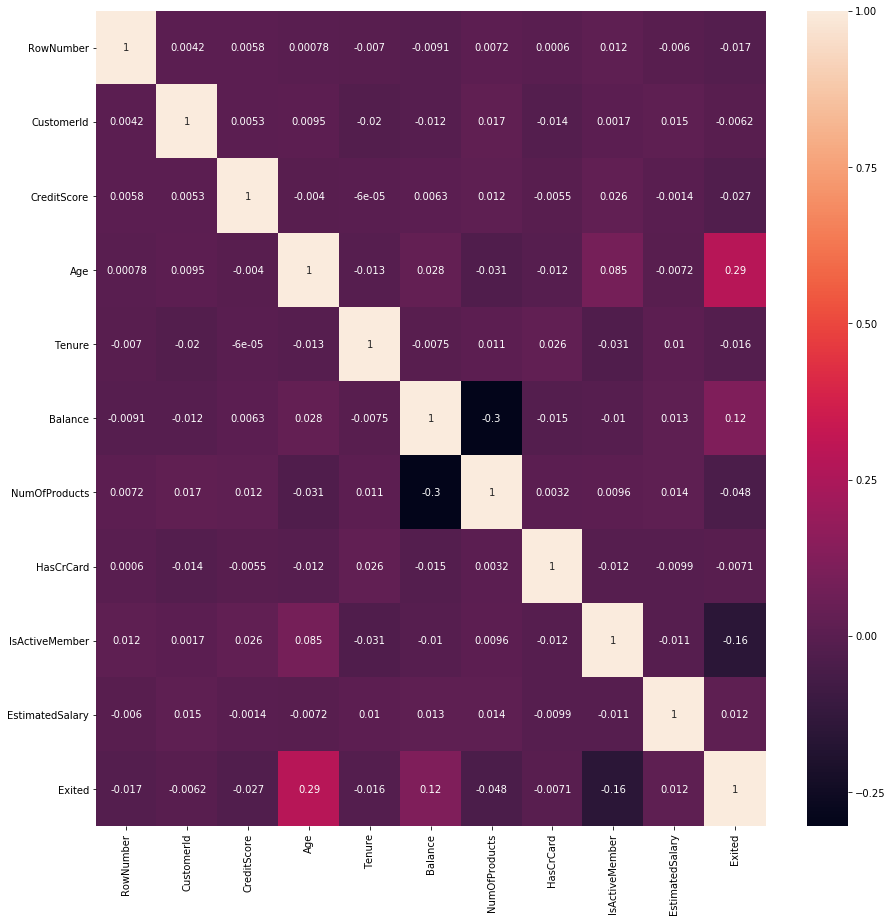

In [4]:
corr = df.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True)

In [5]:
df.corr()['Exited'].reset_index().sort_values(by='Exited',ascending=False).reset_index().drop('level_0', axis=1)

,index,Exited
0,Exited,1.000000
1,Age,0.285323
2,Balance,0.118533
3,EstimatedSalary,0.012097
4,CustomerId,-0.006248
5,HasCrCard,-0.007138
6,Tenure,-0.015989
7,RowNumber,-0.016571
8,CreditScore,-0.027094
9,NumOfProducts,-0.047820


Самая сильная связь оказалась в колонках с возрастом, остатком на счету и активностью клиента. Проверим, нет ли в этих данных смещения в ту или иную сторону

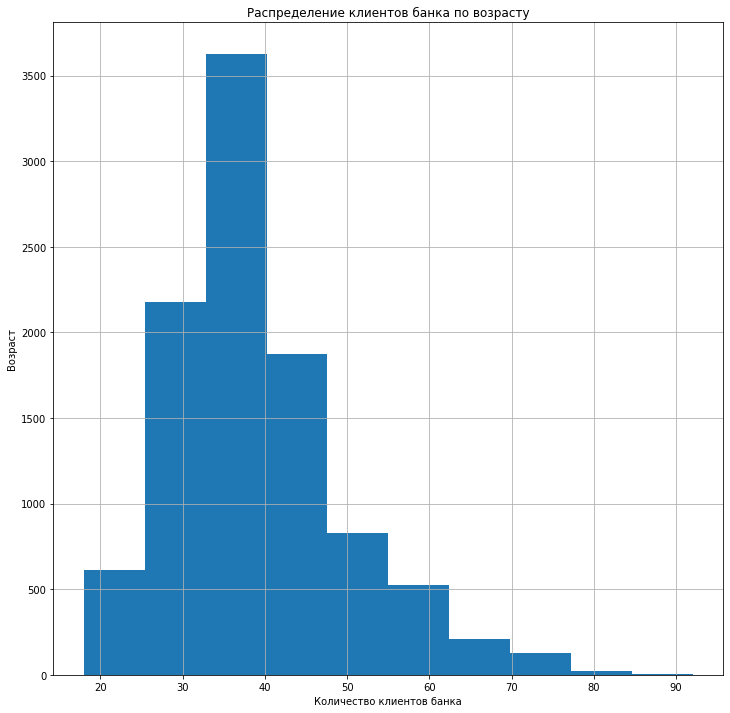

In [6]:
plt.figure(figsize=(12,12))
plt.xlabel('Количество клиентов банка')
plt.ylabel('Возраст')
plt.title('Распределение клиентов банка по возрасту')
df['Age'].hist()

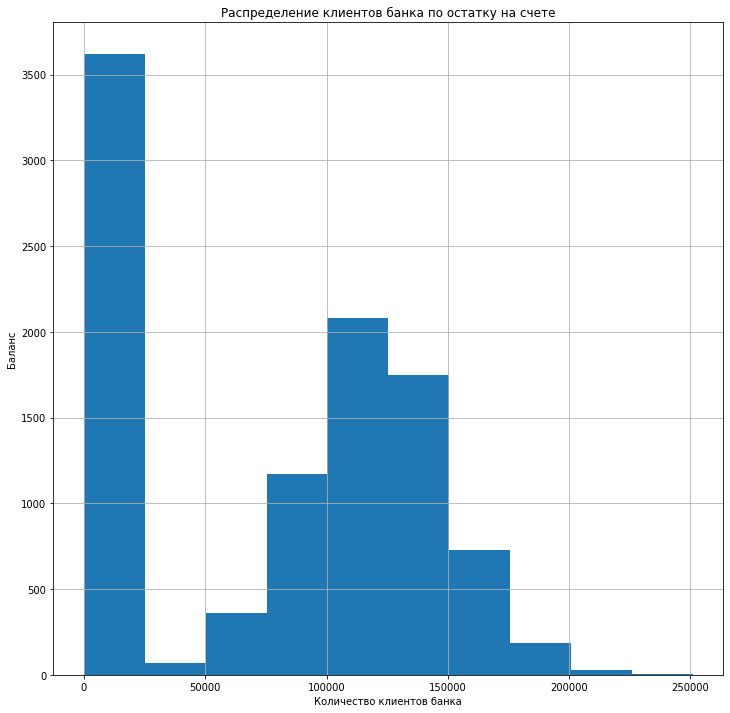

In [7]:
plt.figure(figsize=(12,12))
plt.xlabel('Количество клиентов банка')
plt.ylabel('Баланс')
plt.title('Распределение клиентов банка по остатку на счете')
df['Balance'].hist()

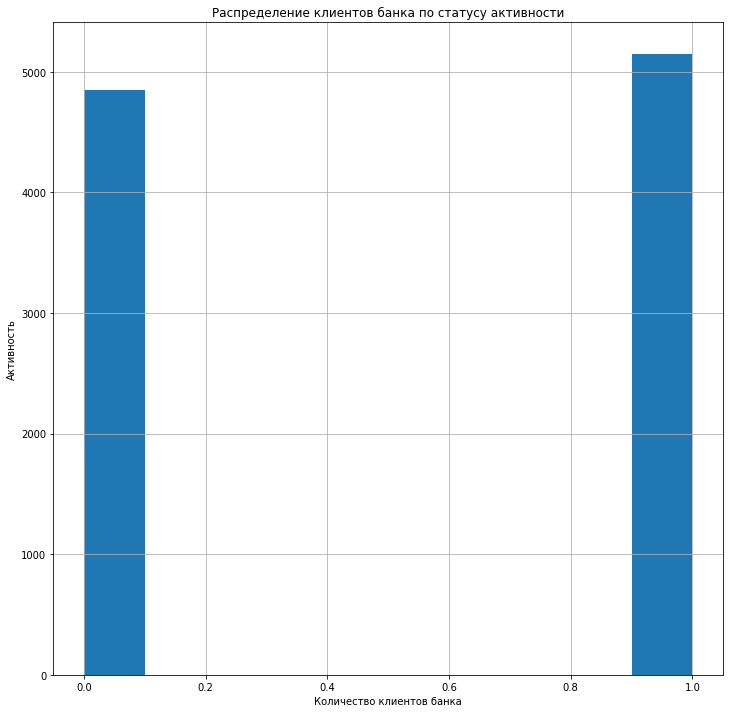

In [8]:
plt.figure(figsize=(12,12))
plt.xlabel('Количество клиентов банка')
plt.ylabel('Активность')
plt.title('Распределение клиентов банка по статусу активности')
df['IsActiveMember'].hist()

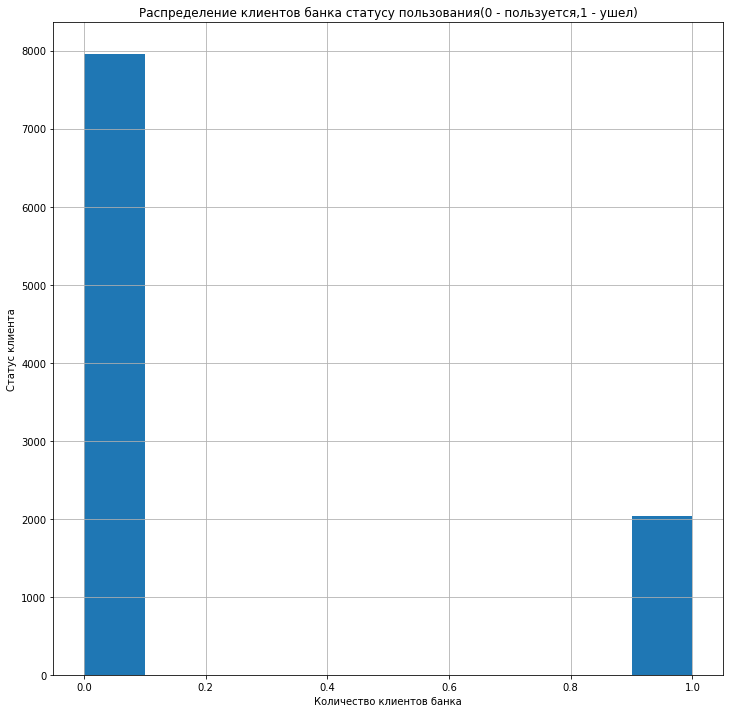

In [9]:
plt.figure(figsize=(12,12))
plt.xlabel('Количество клиентов банка')
plt.ylabel('Статус клиента')
plt.title('Распределение клиентов банка статусу пользования(0 - пользуется,1 - ушел)')
df['Exited'].hist()

В данных присутствует очевидное смещение данных в ту или иную сторону во всех колонках, кроме статуса активности. Значит придется балансировать данные при обучении модели.

Проверим, влияет ли большое количество пользователей с нулевым балансом на зависимость между признаками.

,index,Exited
0,Exited,1.000000
1,Age,0.285323
2,Balance,0.118533
3,EstimatedSalary,0.012097
4,CustomerId,-0.006248
5,HasCrCard,-0.007138
6,Tenure,-0.015989
7,RowNumber,-0.016571
8,CreditScore,-0.027094
9,NumOfProducts,-0.047820


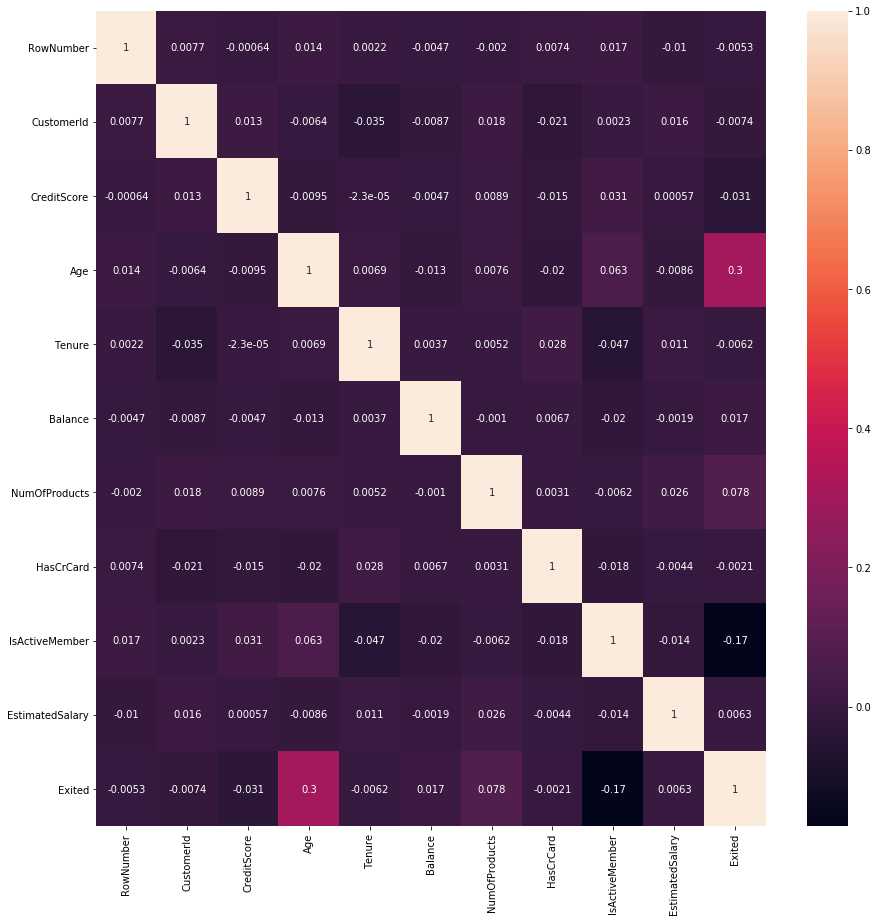

In [10]:
df_new = df.query('Balance!=0').copy()
corr = df_new.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True)
df.corr()['Exited'].reset_index().sort_values(by='Exited',ascending=False).reset_index().drop('level_0', axis=1)

Зависимости не выявлено. Попробуем теперь построить модель, предсказывающую уход клиента, но сначала используем только те признаки, зависимость с которыми достаточно высока. Предварительно разделим датасет на три выборки: обучающую, валидационную и тестовую.

In [11]:
features = df[['Age', 'Balance', 'IsActiveMember']]
target = df['Exited']
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    test_size = 0.2, random_state = 42)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
                                                    test_size = 0.33, random_state = 42)
print(features_train.shape , features_valid.shape, features_test.shape , target_train.shape , target_valid.shape 
      , target_test.shape )

(5360, 3) (2640, 3) (2000, 3) (5360,) (2640,) (2000,)


Начнём построение моделей. Первой моделью проверим дерево решений. Для подбора наилучших параметров переберем различные значения глубины решающего дерева, контроль наилучшей модели будем осуществлять по среднему гармоническому полученной модели.

In [12]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
for depth in range(1, 51):
    tree_model = DecisionTreeClassifier(random_state = 42, max_depth = depth)
    tree_model.fit(features_train, target_train)
    tree_predictions_valid = tree_model.predict(features_valid)
    tree_result = f1_score(target_valid, tree_predictions_valid)
    if tree_result > best_tree_result:
            best_tree_model = tree_model
            best_tree_result = tree_result
            best_tree_depth = depth
print("Лучшая f1:", best_tree_result,  "Максимальная глубина:", depth, "Лучшая глубина:", best_tree_depth)

Лучшая f1: 0.4640883977900553 Максимальная глубина: 50 Лучшая глубина: 2


Таким же образом проверим лес решений. Подберем экспериментально количество деревьев и глубину, оценку будем вести по тому же параметру.

In [13]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 110, 5):
    for depth in range (1, 50):
        forest_model = RandomForestClassifier(random_state=42, n_estimators = est, max_depth = depth)
        forest_model.fit(features_train, target_train)
        forest_predictions_valid = forest_model.predict(features_valid)
        forest_result = f1_score(target_valid, forest_predictions_valid)
        if forest_result > best_forest_result:
            best_forest_model = forest_model
            best_forest_result = forest_result
            best_forest_est = est
            best_forest_depth = depth
print("Лучшая f1:", best_forest_result, "Количество деревьев:", best_forest_est, "Максимальная глубина:", depth,
        "Лучшая глубина:", best_forest_depth)

Лучшая f1: 0.4227272727272727 Количество деревьев: 45 Максимальная глубина: 49 Лучшая глубина: 14


Последней моделью является логистическая регрессия.

In [14]:
regression_model = LogisticRegression(random_state = 42)
regression_model.fit(features_train, target_train)
regression_predictions_valid = regression_model.predict(features_valid)
regression_result = f1_score(target_valid, regression_predictions_valid)
print("f1 модели на валидационной выборке:", regression_result)

f1 модели на валидационной выборке: 0.0


Посмотрим на остальные метрики качества моделей.

In [15]:
print("Полнота модели дерева решений", recall_score(target_valid, tree_predictions_valid))
print("Точность модели дерева решений", precision_score(target_valid, tree_predictions_valid))

Полнота модели дерева решений 0.3442028985507246
Точность модели дерева решений 0.42410714285714285


In [16]:
print("Полноста модели леса решений",recall_score(target_valid, forest_predictions_valid))
print("Точность модели леса решений",precision_score(target_valid, forest_predictions_valid))

Полноста модели леса решений 0.3278985507246377
Точность модели леса решений 0.4839572192513369


In [17]:
print("Полнота модели логистической регрессии",recall_score(target_valid, regression_predictions_valid))
print("Точность модели логистической регрессии",precision_score(target_valid, regression_predictions_valid))

Полнота модели логистической регрессии 0.0
Точность модели логистической регрессии 0.0


Полученный результат никуда не годится. Очевидно, что выбранных нами изначально признаков недостаточно, поэтому добавим оставшиеся колонки для уточнения анализа. Данные об id клиента и его имени для нас бесполезны, их просто выбросим. Текстовые признаки преобразуем в численные методом ОНЕ, не забыв отбросить первую колонку воизбежание попадания в dummy-ловушку.

In [18]:
df=df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df = pd.get_dummies(df, drop_first=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


Новые данные подготовлены, заново разобьем датасет на три выборки и так же прогоним модели для определения наилучших параметров последующего анализа и прогнозирования

In [20]:
features = df.drop('Exited', axis=1)
target = df['Exited']
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    test_size = 0.2, random_state = 42)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
                                                    test_size = 0.33, random_state = 42)
print(features_train.shape , features_valid.shape, features_test.shape , target_train.shape , target_valid.shape 
      , target_test.shape )

(5360, 11) (2640, 11) (2000, 11) (5360,) (2640,) (2000,)


Модель дерева решений:

In [21]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
for depth in range(1, 51):
    tree_model = DecisionTreeClassifier(random_state = 42, max_depth = depth)
    tree_model.fit(features_train, target_train)
    tree_predictions_valid = tree_model.predict(features_valid)
    tree_result = f1_score(target_valid, tree_predictions_valid)
    if tree_result > best_tree_result:
            best_tree_model = tree_model
            best_tree_result = tree_result
            best_tree_depth = depth
print("Лучшая f1:", best_tree_result,  "Максимальная глубина:", depth, "Лучшая глубина:", best_tree_depth)

Лучшая f1: 0.5727170236753101 Максимальная глубина: 50 Лучшая глубина: 7


Модель леса решений:

In [22]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 110, 5):
    for depth in range (1, 50):
        forest_model = RandomForestClassifier(random_state=42, n_estimators = est, max_depth = depth)
        forest_model.fit(features_train, target_train)
        forest_predictions_valid = forest_model.predict(features_valid)
        forest_result = f1_score(target_valid, forest_predictions_valid)
        if forest_result > best_forest_result:
            best_forest_model = forest_model
            best_forest_result = forest_result
            best_forest_est = est
            best_forest_depth = depth
print("Лучшая f1:", best_forest_result, "Количество деревьев:", best_forest_est, "Максимальная глубина:", depth,
        "Лучшая глубина:", best_forest_depth)

Лучшая f1: 0.605464480874317 Количество деревьев: 35 Максимальная глубина: 49 Лучшая глубина: 26


Модель логистической регрессии:

In [23]:
regression_model = LogisticRegression(random_state = 42)
regression_model.fit(features_train, target_train)
regression_predictions_valid = regression_model.predict(features_valid)
regression_result = f1_score(target_valid, regression_predictions_valid)
print("f1 модели на валидационной выборке:", regression_result)

f1 модели на валидационной выборке: 0.11944869831546706


Наиболее близкой к правде оказалась модель леса решений, среднее гармоническое её предсказания равняется примерно 0,6. Однако, в начале мы обнаружили дисбаланс в классах, поэтому попробуем с ним побороться и проверим, что из этого вышло

## Борьба с дисбалансом

Для борьбы с дисбалансом прибегнем к трём методам: балансирование классов, увеличение и уменьшение выборки. Первым делом прогоним наши модели с подобранными параметрами, однако в этот раз передадим из аргумент class_weight='balanced'. Это позволит сбалансировать классы

In [26]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
for depth in range(1, 51):
    tree_model = DecisionTreeClassifier(random_state = 42, max_depth = depth, class_weight='balanced')
    tree_model.fit(features_train, target_train)
    tree_predictions_valid = tree_model.predict(features_valid)
    tree_result = f1_score(target_valid, tree_predictions_valid)
    if tree_result > best_tree_result:
            best_tree_model = tree_model
            best_tree_result = tree_result
            best_tree_depth = depth
print("Лучшая f1:", best_tree_result,  "Максимальная глубина:", depth, "Лучшая глубина:", best_tree_depth)

Лучшая f1: 0.5684790089470062 Максимальная глубина: 50 Лучшая глубина: 8


In [27]:
print("Accuracy модели дерева решений", accuracy_score(target_valid, tree_predictions_valid))
print("Полнота модели дерева решений",recall_score(target_valid, tree_predictions_valid))
print("Точность модели дерева решений",precision_score(target_valid, tree_predictions_valid))

Accuracy модели дерева решений 0.7852272727272728
Полнота модели дерева решений 0.4782608695652174
Точность модели дерева решений 0.4861878453038674


Взглянем на ROC кривую для полученной модели.

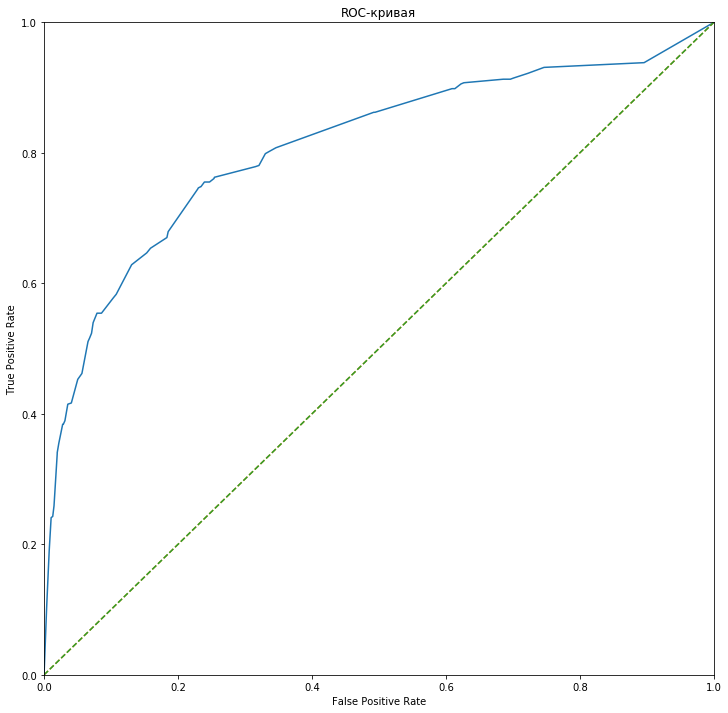

ROC-AUC модели дерева решений 0.808984830501416


In [30]:
probability = best_tree_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC модели дерева решений",auc)

Модель Показывает достаточно неплохой результат, а ROC-AUC значительно отличается от показателя для модели, случайно угадвающей результат. Проведем такой же эксперимент для модели леса решений. 

In [32]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 55, 5):
    for depth in range (1, 50):
        forest_model = RandomForestClassifier(random_state=42, n_estimators = est, max_depth = depth, class_weight='balanced')
        forest_model.fit(features_train, target_train)
        forest_predictions_valid = forest_model.predict(features_valid)
        forest_result = f1_score(target_valid, forest_predictions_valid)
        if forest_result > best_forest_result:
            best_forest_model = forest_model
            best_forest_result = forest_result
            best_forest_est = est
            best_forest_depth = depth
print("Лучшая f1:", best_forest_result, "Количество деревьев:", best_forest_est, "Максимальная глубина:", depth,
        "Лучшая глубина:", best_forest_depth)

Лучшая f1: 0.6286248830682882 Количество деревьев: 20 Максимальная глубина: 49 Лучшая глубина: 11


In [33]:
print("Accuracy модели леса решений",accuracy_score(target_valid, forest_predictions_valid))
print("Полнота модели леса решений",recall_score(target_valid, forest_predictions_valid))
print("Точность модели леса решений",precision_score(target_valid, forest_predictions_valid))

Accuracy модели леса решений 0.8598484848484849
Полнота модели леса решений 0.46557971014492755
Точность модели леса решений 0.7740963855421686


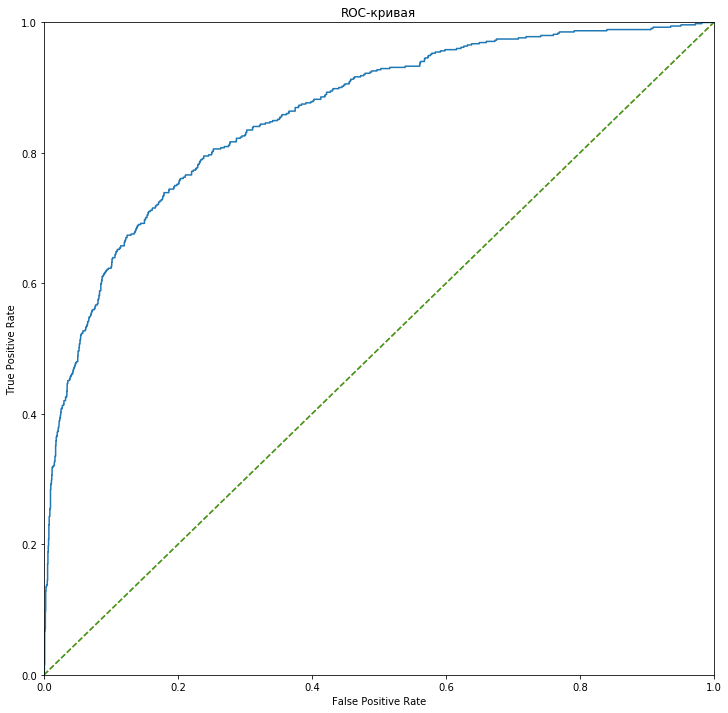

ROC-AUC модели леса решений 0.8586223381364873


In [34]:
probability = best_forest_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC модели леса решений",auc)

Модель леса показывает более уверенный результат. Проверим теперь модель логистической регрессии.

In [35]:
regression_model = LogisticRegression(random_state = 42, class_weight='balanced')
regression_model.fit(features_train, target_train)
regression_predictions_valid = regression_model.predict(features_valid)

In [36]:
print("Accuracy модели регрессии",accuracy_score(target_valid, regression_predictions_valid))
print("Полнота модели регрессии",recall_score(target_valid, regression_predictions_valid))
print("Точность модели регрессии",precision_score(target_valid, regression_predictions_valid))
print("F1 модели регрессии",f1_score(target_valid, regression_predictions_valid))

Accuracy модели регрессии 0.6712121212121213
Полнота модели регрессии 0.6884057971014492
Точность модели регрессии 0.35315985130111527
F1 модели регрессии 0.46683046683046686


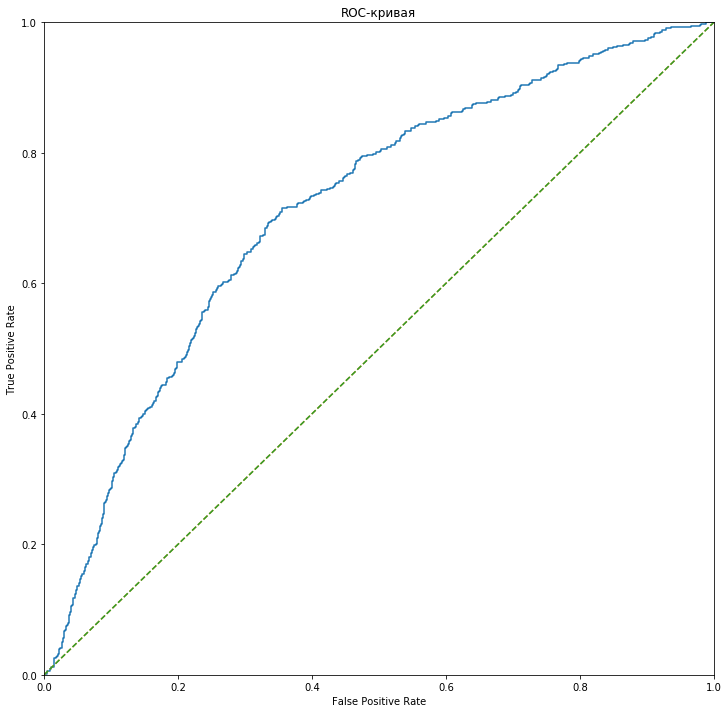

ROC-AUC модели логистической регрессии 0.7127304403353879


In [37]:
probability = regression_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC модели логистической регрессии",auc)

К сожалению, модель регрессии показала худший результат.

Еще двумя способами борьбы с дисбалансом является увеличение и уменьшение выборки. Предварительно необходимо придать одинаковый вес признакам, как мы помним из анализа вначале, у нас имеются смещения в ту или иную стороную. Для этого преобразуем признаки инструментом scaler.

In [38]:
numeric = ['Age', 'Balance', 'IsActiveMember']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.info()
features_valid.info()
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5360 entries, 665 to 6090
Data columns (total 11 columns):
CreditScore          5360 non-null int64
Age                  5360 non-null float64
Tenure               5360 non-null int64
Balance              5360 non-null float64
NumOfProducts        5360 non-null int64
HasCrCard            5360 non-null int64
IsActiveMember       5360 non-null float64
EstimatedSalary      5360 non-null float64
Geography_Germany    5360 non-null uint8
Geography_Spain      5360 non-null uint8
Gender_Male          5360 non-null uint8
dtypes: float64(4), int64(4), uint8(3)
memory usage: 392.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2640 entries, 3188 to 812
Data columns (total 11 columns):
CreditScore          2640 non-null int64
Age                  2640 non-null float64
Tenure               2640 non-null int64
Balance              2640 non-null float64
NumOfProducts        2640 non-null int64
HasCrCard            2640 non-null int64
IsActiveMem

Напишем функции для увеличения и уменьшения выборки и преобразуем наши признаки.

In [39]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

In [40]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 5)

In [41]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

In [42]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.49)

Проверим наши модели на увеличенных выборках.

In [43]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
for depth in range(1, 51):
    tree_model = DecisionTreeClassifier(random_state = 42, max_depth = depth)
    tree_model.fit(features_train_upsampled, target_train_upsampled)
    tree_predictions_valid = tree_model.predict(features_valid)
    tree_result = f1_score(target_valid, tree_predictions_valid)
    if tree_result > best_tree_result:
            best_tree_model = tree_model
            best_tree_result = tree_result
            best_tree_depth = depth
print("Лучшая f1:", best_tree_result,  "Максимальная глубина:", depth, "Лучшая глубина:", best_tree_depth)

Лучшая f1: 0.5588035350101971 Максимальная глубина: 50 Лучшая глубина: 8


In [44]:
print("Accuracy модели дерева решений", accuracy_score(target_valid, tree_predictions_valid))
print("Полнота модели дерева решений",recall_score(target_valid, tree_predictions_valid))
print("Точность модели дерева решений",precision_score(target_valid, tree_predictions_valid))

Accuracy модели дерева решений 0.7928030303030303
Полнота модели дерева решений 0.4927536231884058
Точность модели дерева решений 0.5046382189239332


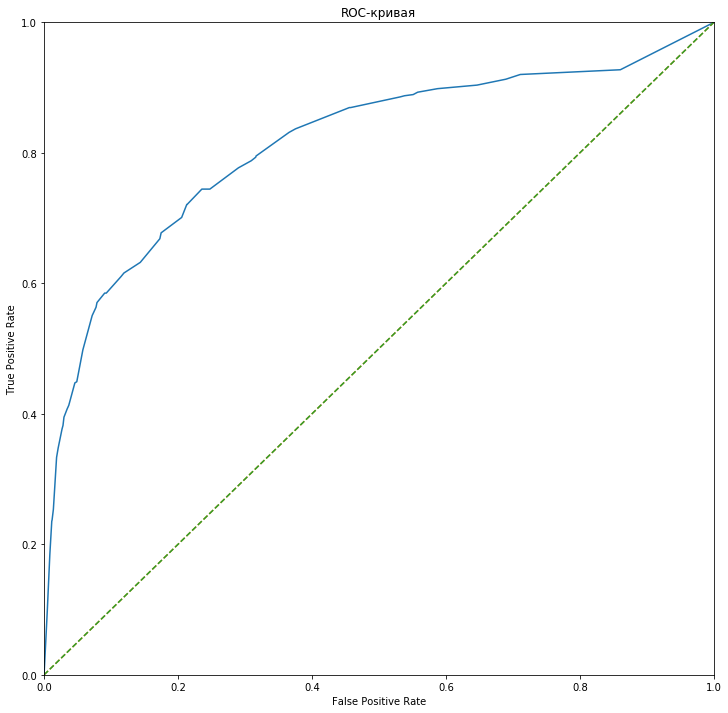

ROC-AUC дерева решений  0.813132496251874


In [45]:
probability = best_tree_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC дерева решений ",auc)

Проверим модель леса решений.

In [47]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 55, 5):
    for depth in range (1, 50):
        forest_model = RandomForestClassifier(random_state=42, n_estimators = est, max_depth = depth)
        forest_model.fit(features_train_upsampled, target_train_upsampled)
        forest_predictions_valid = forest_model.predict(features_valid)
        forest_result = f1_score(target_valid, forest_predictions_valid)
        if forest_result > best_forest_result:
            best_forest_model = forest_model
            best_forest_result = forest_result
            best_forest_est = est
            best_forest_depth = depth
print("Лучшая f1:", best_forest_result, "Количество деревьев:", best_forest_est, "Максимальная глубина:", depth,
        "Лучшая глубина:", best_forest_depth)

Лучшая f1: 0.6297029702970296 Количество деревьев: 40 Максимальная глубина: 49 Лучшая глубина: 21


In [48]:
print("Accuracy модели леса решений",accuracy_score(target_valid, forest_predictions_valid))
print("Полнота модели леса решений",recall_score(target_valid, forest_predictions_valid))
print("Точность модели леса решений",precision_score(target_valid, forest_predictions_valid))

Accuracy модели леса решений 0.8488636363636364
Полнота модели леса решений 0.5471014492753623
Точность модели леса решений 0.6696230598669624


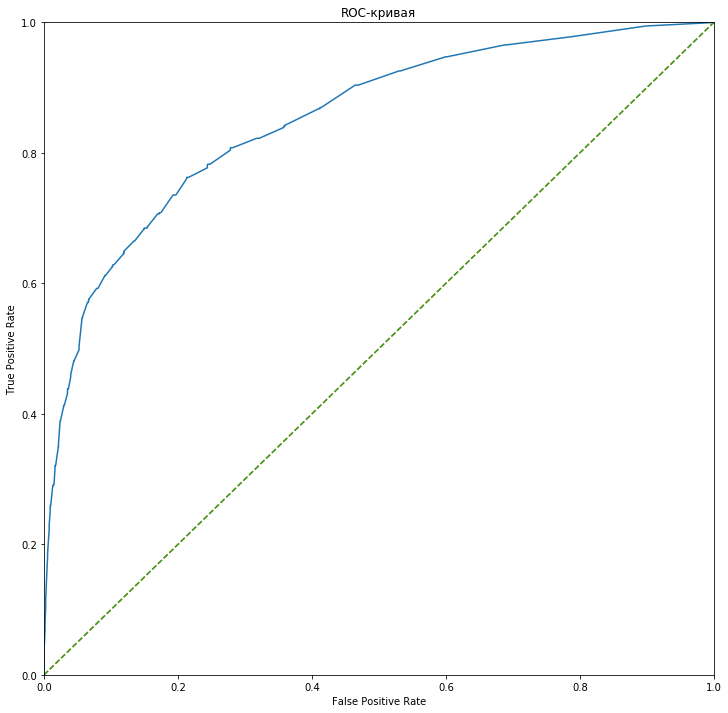

ROC-AUC леса решений  0.8509768553223389


In [49]:
probability = best_forest_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC леса решений ", auc)

И последней моделью будет регрессия

In [50]:
regression_model = LogisticRegression(random_state = 42)
regression_model.fit(features_train_upsampled, target_train_upsampled)
regression_predictions_valid = regression_model.predict(features_valid)

In [51]:
print("Accuracy модели регрессии",accuracy_score(target_valid, regression_predictions_valid))
print("Полнота модели регрессии",recall_score(target_valid, regression_predictions_valid))
print("Точность модели регрессии",precision_score(target_valid, regression_predictions_valid))
print("F1 модели регрессии",f1_score(target_valid, regression_predictions_valid))

Accuracy модели регрессии 0.20909090909090908
Полнота модели регрессии 1.0
Точность модели регрессии 0.20909090909090908
F1 модели регрессии 0.3458646616541353


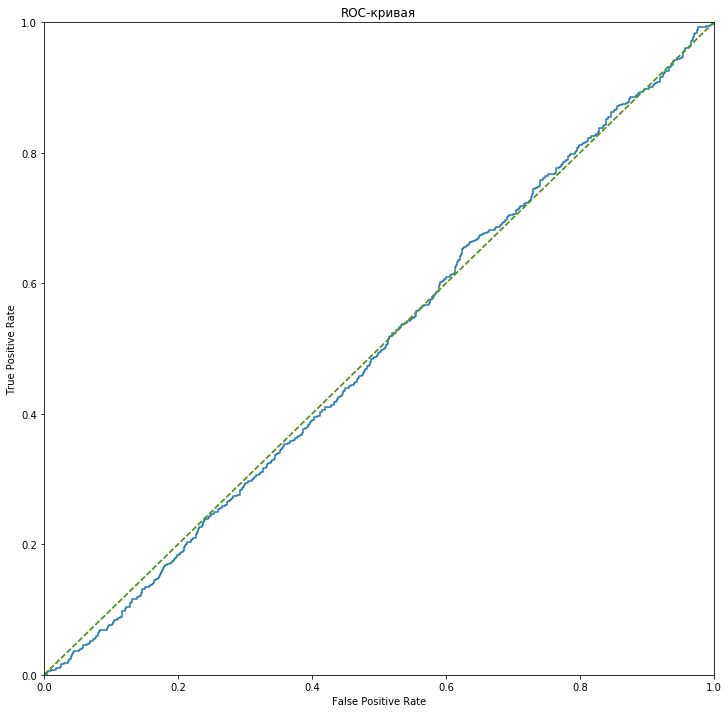

ROC-AUC логистической регрессии  0.4961677147537343


In [52]:
probability = regression_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC логистической регрессии ",auc)

Последним спобсобом борьбы с дисбалансом будет уменьшение выборки

In [53]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
for depth in range(1, 51):
    tree_model = DecisionTreeClassifier(random_state = 42, max_depth = depth)
    tree_model.fit(features_train_downsampled, target_train_downsampled)
    tree_predictions_valid = tree_model.predict(features_valid)
    tree_result = f1_score(target_valid, tree_predictions_valid)
    if tree_result > best_tree_result:
            best_tree_model = tree_model
            best_tree_result = tree_result
            best_tree_depth = depth
print("Лучшая f1:", best_tree_result,  "Максимальная глубина:", depth, "Лучшая глубина:", best_tree_depth)

Лучшая f1: 0.5976027397260274 Максимальная глубина: 50 Лучшая глубина: 5


In [54]:
print("Accuracy модели дерева решений", accuracy_score(target_valid, tree_predictions_valid))
print("Полнота модели дерева решений",recall_score(target_valid, tree_predictions_valid))
print("Точность модели дерева решений",precision_score(target_valid, tree_predictions_valid))

Accuracy модели дерева решений 0.743560606060606
Полнота модели дерева решений 0.6123188405797102
Точность модели дерева решений 0.42197253433208487


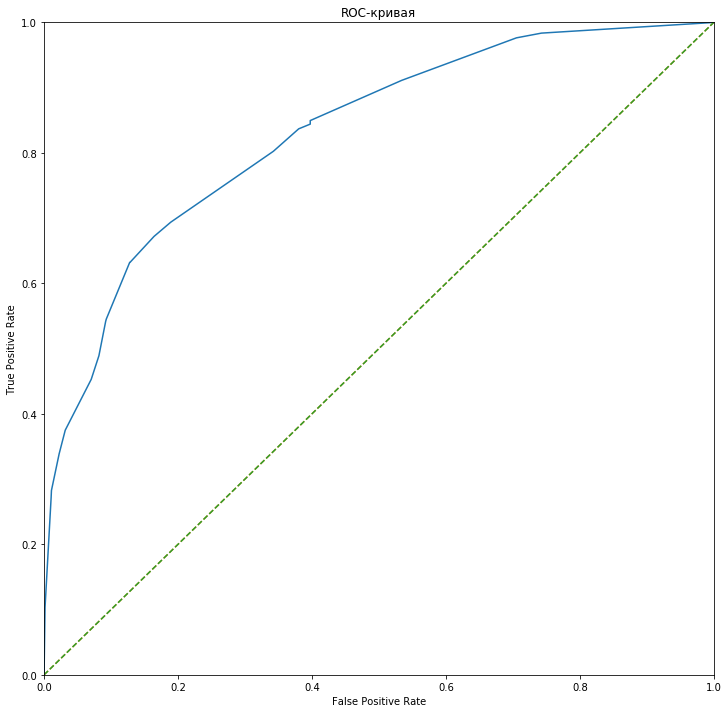

ROC-AUC дерева решений 0.8311074497473485


In [55]:
probability = best_tree_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC дерева решений",auc)

In [56]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 55, 5):
    for depth in range (1, 50):
        forest_model = RandomForestClassifier(random_state=42, n_estimators = est, max_depth = depth)
        forest_model.fit(features_train_downsampled, target_train_downsampled)
        forest_predictions_valid = forest_model.predict(features_valid)
        forest_result = f1_score(target_valid, forest_predictions_valid)
        if forest_result > best_forest_result:
            best_forest_model = forest_model
            best_forest_result = forest_result
            best_forest_est = est
            best_forest_depth = depth
print("Лучшая f1:", best_forest_result, "Количество деревьев:", best_forest_est, "Максимальная глубина:", depth,
        "Лучшая глубина:", best_forest_depth)

Лучшая f1: 0.6363636363636364 Количество деревьев: 35 Максимальная глубина: 49 Лучшая глубина: 21


In [57]:
print("Accuracy модели леса решений",accuracy_score(target_valid, forest_predictions_valid))
print("Полнота модели леса решений",recall_score(target_valid, forest_predictions_valid))
print("Точность модели леса решений",precision_score(target_valid, forest_predictions_valid))

Accuracy модели леса решений 0.8458333333333333
Полнота модели леса решений 0.6159420289855072
Точность модели леса решений 0.6355140186915887


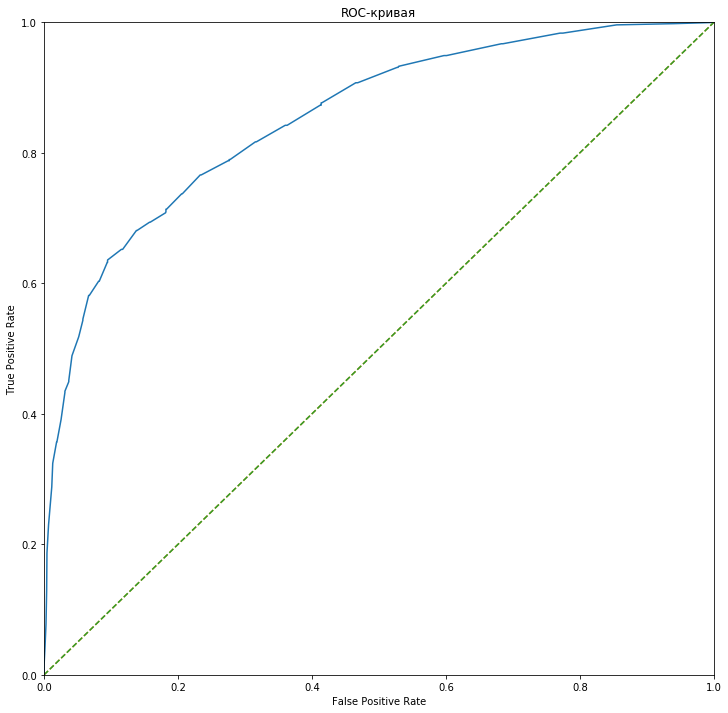

ROC-AUC леса решений 0.8536218002110055


In [58]:
probability = best_forest_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC леса решений",auc)

In [59]:
regression_model.fit(features_train_downsampled, target_train_downsampled)
regression_predictions_valid = regression_model.predict(features_valid)

In [60]:
print("Accuracy модели регрессии",accuracy_score(target_valid, regression_predictions_valid))
print("Полнота модели регрессии",recall_score(target_valid, regression_predictions_valid))
print("Точность модели регрессии",precision_score(target_valid, regression_predictions_valid))
print("F1 модели регрессии",f1_score(target_valid, regression_predictions_valid))

Accuracy модели регрессии 0.7909090909090909
Полнота модели регрессии 0.0
Точность модели регрессии 0.0
F1 модели регрессии 0.0


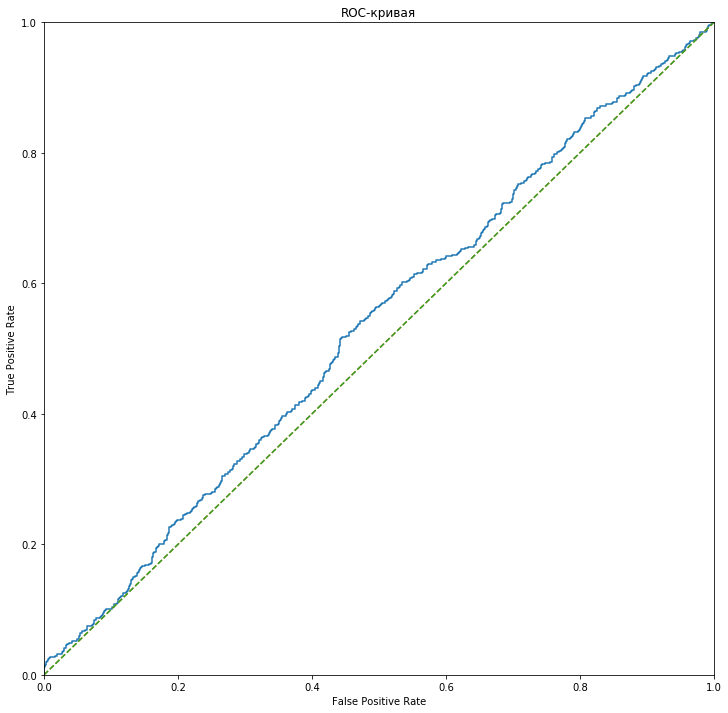

ROC-AUC логистической регрессии 0.5309766991504248


In [61]:
probability = regression_model.predict_proba(features_valid)
fpr, tpr, thx = roc_curve(target_valid,  probability[:,1])
auc = roc_auc_score(target_valid, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC логистической регрессии",auc)

По итогам проделаннх экспериментов можно сделать следующие выводы: модель логистической регрессии не справилась со своей задачей ни в одном из проверенных вариантов. Модель дерева решений показала себя с гораздо лучшей стороны, однако лучшей оказалась модель леса решений, наибольшей эффективностью обладает метод уменьшения выборки.

## Тестирование модели

In [65]:
forest_model = RandomForestClassifier(random_state=42, n_estimators = 35, max_depth = 21)
forest_model.fit(features_train_downsampled, target_train_downsampled)
forest_predictions_test = forest_model.predict(features_test)

In [66]:
print("Accuracy модели леса решений",accuracy_score(target_test, forest_predictions_test))
print("F1 модели леса решений",f1_score(target_test, forest_predictions_test))

Accuracy модели леса решений 0.845
F1 модели леса решений 0.6191646191646192


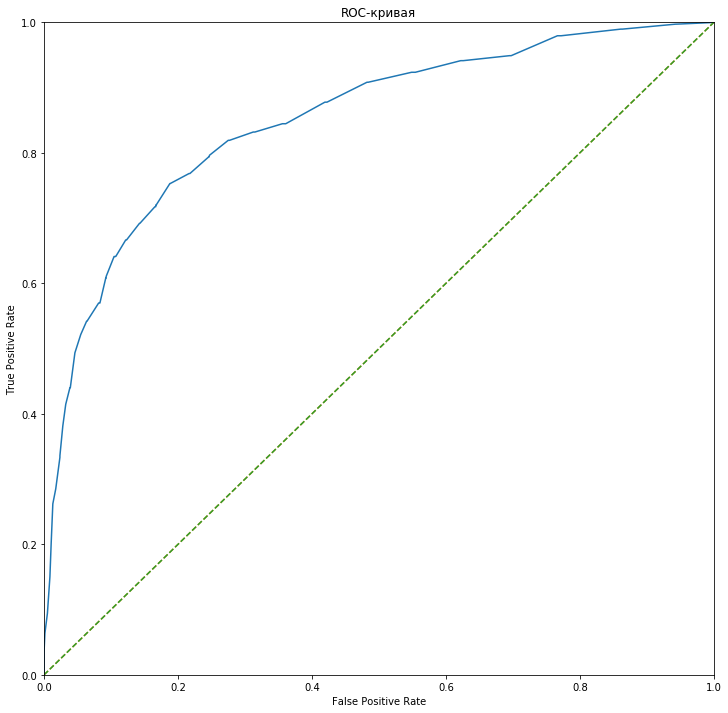

ROC-AUC леса решений для тестовой выборки 0.8499788615646242


In [67]:
probability = forest_model.predict_proba(features_test)
fpr, tpr, thx = roc_curve(target_test,  probability[:,1])
auc = roc_auc_score(target_test, probability[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 
print("ROC-AUC леса решений для тестовой выборки",auc)

Показатели модели на тестовой выборке оказались несколько хуже, чем на валидационной.Это говорит нам о том, что даже выбранная модель далека от совершенства и нуждается в доработках. Однако, точность её предсказаний достаточно высока для решения задачи прогнозирования, а её предсказания значительно далеки от предсказаний модели, угадывающей результаты случайно.

**Вывод**: по результатам исследования удалось найти оптимальную модель, предсказывающую потенциальный уход клиента. При прогнозировании следует учитывать все признаки для достижения наиболее точного результата даже несмотря на то, что иногда корреляции между ними нет. Более того, так как баланса классов на реальных данных клиентов быть не может(такое встречается только в идеальных условиях теоретических задач), следует принять этот факт во внимание. В данном исследовании с лучшей стороны показала себя стратегия уменьшения выборки классов, в рабочей моделью выбрана модель случайного леса. В эксперименте удалось достичь точность предсказания на уровне 0,845 и среднего гармоническоно более 0,6, что свидетельствует о высоком качестве рабочей модели. 